## Train Delay Prediction Project

### Step 1: Cleaning the Main `Trains` Sheet

This step loads and cleans the master train information from the `Trains` sheet:

- Drops the first row which contains a repeated header or empty placeholder
- Renames unnamed columns corresponding to days of the week (`Mon` to `Sun`)
- Converts key columns to appropriate data types:
  - `Train Number`, `Coach Count`, `Number of Days` to numeric (where valid)
  - `Is Pantry Available` to boolean
- Strips leading/trailing spaces in text columns like `Train Name`, `Type`, `Zone`, etc.

The result is a clean and structured DataFrame `df_trains` that will be used for merging and modeling in later steps.


In [251]:
import pandas as pd

file_path = 'TrainsData.xlsx'
xls = pd.ExcelFile(file_path)

df_trains = xls.parse('Trains')

# Dropping the first row which seems to be a repeated header or empty
df_trains = df_trains.drop(index=0).reset_index(drop=True)

# Renaming columns for days of week which are currently unnamed
# The 11th column onward correspond to days of run (Mon to Sun)
df_trains.columns = ['Train Number', 'Train Name', 'Type', 'Zone', 'Coach Count',
                     'Is Pantry Available', 'Number of Days', 'Origin', 'Departure Time',
                     'Destination', 'Arrival Time', 'Travel Time',
                     'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Classes']

# Converting Train Number to integer (assumed mandatory)
df_trains['Train Number'] = df_trains['Train Number'].astype(int)

# We'll only convert non-null values to int
df_trains['Coach Count'] = pd.to_numeric(df_trains['Coach Count'], errors='coerce')
df_trains['Number of Days'] = pd.to_numeric(df_trains['Number of Days'], errors='coerce')

# Converting Is Pantry Available to boolean (Yes/No → True/False)
df_trains['Is Pantry Available'] = df_trains['Is Pantry Available'].map({'Yes': True, 'No': False})

# Cleaning text columns: stripping whitespace from Type, Zone, Origin, Destination, Classes
text_columns = ['Train Name', 'Type', 'Zone', 'Origin', 'Destination', 'Classes']
for col in text_columns:
    df_trains[col] = df_trains[col].astype(str).str.strip()

# Checking and reporting missing values
missing_report = df_trains.isnull().sum()
print("Missing values in each column:\n", missing_report)

# Previewing cleaned dataset
df_trains.head()

Missing values in each column:
 Train Number           0
Train Name             0
Type                   0
Zone                   0
Coach Count            1
Is Pantry Available    0
Number of Days         0
Origin                 0
Departure Time         0
Destination            0
Arrival Time           0
Travel Time            0
Mon                    0
Tue                    0
Wed                    0
Thu                    0
Fri                    0
Sat                    0
Sun                    0
Classes                0
dtype: int64


,Train Number,Train Name,Type,Zone,Coach Count,Is Pantry Available,Number of Days,Origin,Departure Time,Destination,Arrival Time,Travel Time,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Classes
0,12649,SAMPARK KRANTI,Super Fast,SWR,21.0,True,5.0,YPR,13:00:00,NZM,08:10:00,"1 day, 19:10:00",Y,N,Y,N,Y,Y,Y,1A SL 3E 3A 2A
1,22685,CDG SKRANTI EXP,Super Fast,SWR,23.0,False,2.0,YPR,14:45:00,NDLS,11:55:00,"1 day, 21:10:00",N,N,Y,N,N,Y,N,1A CC SL 3A 2A
2,12627,KARNATAKA EXP,Super Fast,SWR,23.0,True,7.0,SBC,19:20:00,NDLS,09:00:00,"1 day, 13:40:00",Y,Y,Y,Y,Y,Y,Y,1A SL 3A 2A
3,22691,RAJDHANI EXP,Rajdhani,SWR,22.0,True,7.0,SBC,20:00:00,NZM,05:30:00,"1 day, 9:30:00",Y,Y,Y,Y,Y,Y,Y,1A 3A 2A
4,12213,YPR DEE DURONTO,Duronto,SWR,20.0,True,1.0,YPR,23:40:00,DEE,07:50:00,"1 day, 8:10:00",N,N,N,N,N,Y,N,1A 3A 2A


### Step 2: Extracting Monthly Delay Information for Delhi

This step extracts monthly delay metrics from each per-train sheet in the Excel file:

- For each train sheet, selects the **last station**, which is always a Delhi station
- From each month’s tuple column (`(Min, Max, Mode)`), it extracts:
  - `<Month>_Min`, `<Month>_Max`, and `<Month>_Average` (where Average = Mode)
- Handles missing or malformed data gracefully
- Creates one row per train with all 36 values (12 months × 3 values)

The result is a DataFrame `delay_df` containing delay metrics per train, ready to be joined with other datasets.

In [252]:
import numpy as np
import pandas as pd

xls = pd.ExcelFile('TrainsData.xlsx')

# Get all train sheets except main one
train_sheets = [sheet for sheet in xls.sheet_names if sheet != 'Trains']

# Monthly columns from train sheets
month_columns = ['April (Min,Max,Mode)', 'May (Min,Max,Mode)', 'June(Min,Max,Mode)',
                 'July (Min,Max,Mode)', 'August(Min,Max,Mode)', 'September (Min,Max,Mode)',
                 'October (Min,Max,Mode)', 'November (Min,Max,Mode)', 'December (Min,Max,Mode)',
                 'Jan (Min,Max,Mode)', 'Feb (Min,Max,Mode)', 'March  (Min,Max,Mode)']

month_names = [col.split('(')[0].strip() for col in month_columns]

delay_data = []

for sheet in train_sheets:
    df = xls.parse(sheet)

    # Skip empty sheets
    if df.empty:
        print(f"Skipping empty sheet: {sheet}")
        continue

    last_row = df.iloc[-1]
    row_values = [int(sheet)]  # Start with Train Number

    for col in month_columns:
        if col in last_row and pd.notnull(last_row[col]):
            try:
                parsed = eval(str(last_row[col]))
                if isinstance(parsed, tuple) and len(parsed) == 3:
                    row_values.extend([parsed[0], parsed[1], parsed[2]])  # Min, Max, Mode (Average)
                else:
                    row_values.extend([np.nan, np.nan, np.nan])
            except:
                row_values.extend([np.nan, np.nan, np.nan])
        else:
            row_values.extend([np.nan, np.nan, np.nan])

    delay_data.append(row_values)

columns = ['Train Number']
for month in month_names:
    columns.extend([f"{month}_Min", f"{month}_Max", f"{month}_Average"])

delay_df = pd.DataFrame(delay_data, columns=columns)

delay_df.head()

Skipping empty sheet: 12471


,Train Number,April_Min,April_Max,April_Average,May_Min,May_Max,May_Average,June_Min,June_Max,June_Average,...,December_Average,Jan_Min,Jan_Max,Jan_Average,Feb_Min,Feb_Max,Feb_Average,March_Min,March_Max,March_Average
0,12649,0.0,207.0,98.0,13.0,286.0,115.0,0.0,321.0,68.0,...,75.0,-1.0,266.0,180.0,-1.0,119.0,100.0,-4.0,177.0,70.0
1,22685,2.0,195.0,7.0,0.0,38.0,30.0,1.0,407.0,40.0,...,20.0,8.0,216.0,125.0,8.0,225.0,100.0,7.0,275.0,36.0
2,12627,0.0,289.0,150.0,0.0,159.0,40.0,7.0,301.0,100.0,...,100.0,27.0,3178.0,375.0,16.0,632.0,200.0,0.0,246.0,100.0
3,22691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12213,14.0,134.0,75.0,35.0,141.0,80.0,8.0,234.0,75.0,...,150.0,80.0,173.0,120.0,15.0,131.0,75.0,0.0,70.0,15.0


### Step 3: Extracting Station-Level Route Features from Per-Train Sheets

This step extracts useful features from each train’s route (excluding the final station):
- Number of stations passed through
- Platform stats (average/min/max)
- Terrain types encountered
- Distance covered before Delhi

In [253]:
from collections import Counter

# Creating a list to store station-level features
station_features = []

# Looping through each train sheet already loaded in 'train_sheets'
for sheet in train_sheets:
    df = xls.parse(sheet)

    # Skip empty or very small sheets
    if df.empty or df.shape[0] < 2:
        print(f"Skipping sheet: {sheet}")
        continue

    # Exclude the final station (Delhi)
    route_df = df.iloc[:-1]

    # Basic aggregations
    num_stations = route_df.shape[0]
    total_distance = pd.to_numeric(route_df['Distance'], errors='coerce').sum()

    # Platform stats
    platform_counts = pd.to_numeric(route_df['Number of Platforms'], errors='coerce')
    avg_platform = platform_counts.mean()
    min_platform = platform_counts.min()
    max_platform = platform_counts.max()

    # Terrain features
    terrain_list = route_df['Terrain'].dropna().astype(str).tolist()
    terrain_counter = Counter(terrain_list)
    most_common_terrain = terrain_counter.most_common(1)[0][0] if terrain_counter else None
    unique_terrains = len(terrain_counter)

    # Flatten terrain counts into individual columns
    terrain_features = {}
    for terrain, count in terrain_counter.items():
        terrain_features[f'Terrain_Count_{terrain}'] = count

    # Assemble all features for the train
    row = {
        'Train Number': int(sheet),
        'Num_Stations': num_stations,
        'Total_Distance': total_distance,
        'Avg_Platform_Count': avg_platform,
        'Min_Platform_Count': min_platform,
        'Max_Platform_Count': max_platform,
        'Most_Common_Terrain': most_common_terrain,
        'Num_Unique_Terrains': unique_terrains
    }
    row.update(terrain_features)

    station_features.append(row)

# Create final DataFrame with station-level features
station_df = pd.DataFrame(station_features)

station_df.head()

Skipping sheet: 12471


,Train Number,Num_Stations,Total_Distance,Avg_Platform_Count,Min_Platform_Count,Max_Platform_Count,Most_Common_Terrain,Num_Unique_Terrains,Terrain_Count_Plateau,Terrain_Count_Plains,Terrain_Count_Coastal,Terrain_Count_Plain,Terrain_Count_Hills
0,12649,19,17381.0,4.210526,2.0,8.0,Plateau,1,19.0,NaN,NaN,NaN,NaN
1,22685,15,14196.0,4.866667,3.0,7.0,Plateau,2,14.0,1.0,NaN,NaN,NaN
2,12627,34,31763.0,2.352941,1.0,6.0,Plateau,2,29.0,5.0,NaN,NaN,NaN
3,22691,102,16867.0,2.312500,1.0,9.0,Plateau,2,12.0,4.0,NaN,NaN,NaN
4,12213,7,6890.0,3.142857,1.0,6.0,Plateau,2,6.0,1.0,NaN,NaN,NaN


### Step 4: Merging Train Metadata, Delay Data, and Route Features

In this step, we merge all previously prepared datasets into a single master dataset:

- `df_trains` – Cleaned train metadata
- `delay_df` – Monthly delay info (Min, Max, Average)
- `station_df` – Features extracted from station-wise route info

All merges are performed using the common `Train Number` key.

The resulting `master_df` contains all features required for EDA and modeling.

In [254]:
# Impute missing monthly averages with the column-wise mean
average_cols = [col for col in master_df.columns if '_Average' in col]
master_df[average_cols] = master_df[average_cols].fillna(master_df[average_cols].mean())

# Merge df_trains with delay_df on 'Train Number'
merged_df = pd.merge(df_trains, delay_df, on='Train Number', how='inner')

# Merge the result with station_df
master_df = pd.merge(merged_df, station_df, on='Train Number', how='inner')

print(master_df[average_cols].isnull().sum())
print("Number of valid rows for average delay computation:")
print(master_df[average_cols].dropna().shape[0])

#print(master_df.columns.tolist())
#print(f"Final merged dataset shape: {master_df.shape}")
#master_df.head()

April_Average        18
May_Average          18
June_Average         18
July_Average         18
August_Average       18
September_Average    18
October_Average      18
November_Average     18
December_Average     18
Jan_Average          18
Feb_Average          18
March_Average        18
dtype: int64
Number of valid rows for average delay computation:
12


### Step 5: Exploratory Data Analysis (EDA) – Part 1: Data Overview

This step begins our EDA by understanding the overall structure of the dataset.

- View number of rows and columns
- Examine data types of all columns
- Check for duplicate train entries
- Display basic statistics for numeric columns

In [255]:
print(f"Number of rows: {master_df.shape[0]}")
print(f"Number of columns: {master_df.shape[1]}")

duplicate_trains = master_df['Train Number'].duplicated().sum()
print(f"Number of duplicate Train Numbers: {duplicate_trains}")

print("\nData Types and Column Info:")
master_df.info()

master_df.describe(include='number').T.head(10)  # Displaying first 10 rows for readability

master_df.head()

Number of rows: 30
Number of columns: 68
Number of duplicate Train Numbers: 1

Data Types and Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 68 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Train Number           30 non-null     int64  
 1   Train Name             30 non-null     object 
 2   Type                   30 non-null     object 
 3   Zone                   30 non-null     object 
 4   Coach Count            29 non-null     float64
 5   Is Pantry Available    30 non-null     bool   
 6   Number of Days         30 non-null     float64
 7   Origin                 30 non-null     object 
 8   Departure Time         30 non-null     object 
 9   Destination            30 non-null     object 
 10  Arrival Time           30 non-null     object 
 11  Travel Time            30 non-null     object 
 12  Mon                    30 non-null     object 
 13  Tue  

,Train Number,Train Name,Type,Zone,Coach Count,Is Pantry Available,Number of Days,Origin,Departure Time,Destination,...,Avg_Platform_Count,Min_Platform_Count,Max_Platform_Count,Most_Common_Terrain,Num_Unique_Terrains,Terrain_Count_Plateau,Terrain_Count_Plains,Terrain_Count_Coastal,Terrain_Count_Plain,Terrain_Count_Hills
0,12649,SAMPARK KRANTI,Super Fast,SWR,21.0,True,5.0,YPR,13:00:00,NZM,...,4.210526,2.0,8.0,Plateau,1,19.0,NaN,NaN,NaN,NaN
1,22685,CDG SKRANTI EXP,Super Fast,SWR,23.0,False,2.0,YPR,14:45:00,NDLS,...,4.866667,3.0,7.0,Plateau,2,14.0,1.0,NaN,NaN,NaN
2,12627,KARNATAKA EXP,Super Fast,SWR,23.0,True,7.0,SBC,19:20:00,NDLS,...,2.352941,1.0,6.0,Plateau,2,29.0,5.0,NaN,NaN,NaN
3,22691,RAJDHANI EXP,Rajdhani,SWR,22.0,True,7.0,SBC,20:00:00,NZM,...,2.312500,1.0,9.0,Plateau,2,12.0,4.0,NaN,NaN,NaN
4,12213,YPR DEE DURONTO,Duronto,SWR,20.0,True,1.0,YPR,23:40:00,DEE,...,3.142857,1.0,6.0,Plateau,2,6.0,1.0,NaN,NaN,NaN


### Step 5: EDA – Part 2: Missing Value Analysis

In this step, we:
- Identify which columns contain missing values
- Understand how many values are missing per column
- Determine if missingness is significant (based on % missing)
- Prepare for decisions on how to handle them (e.g., impute or drop)

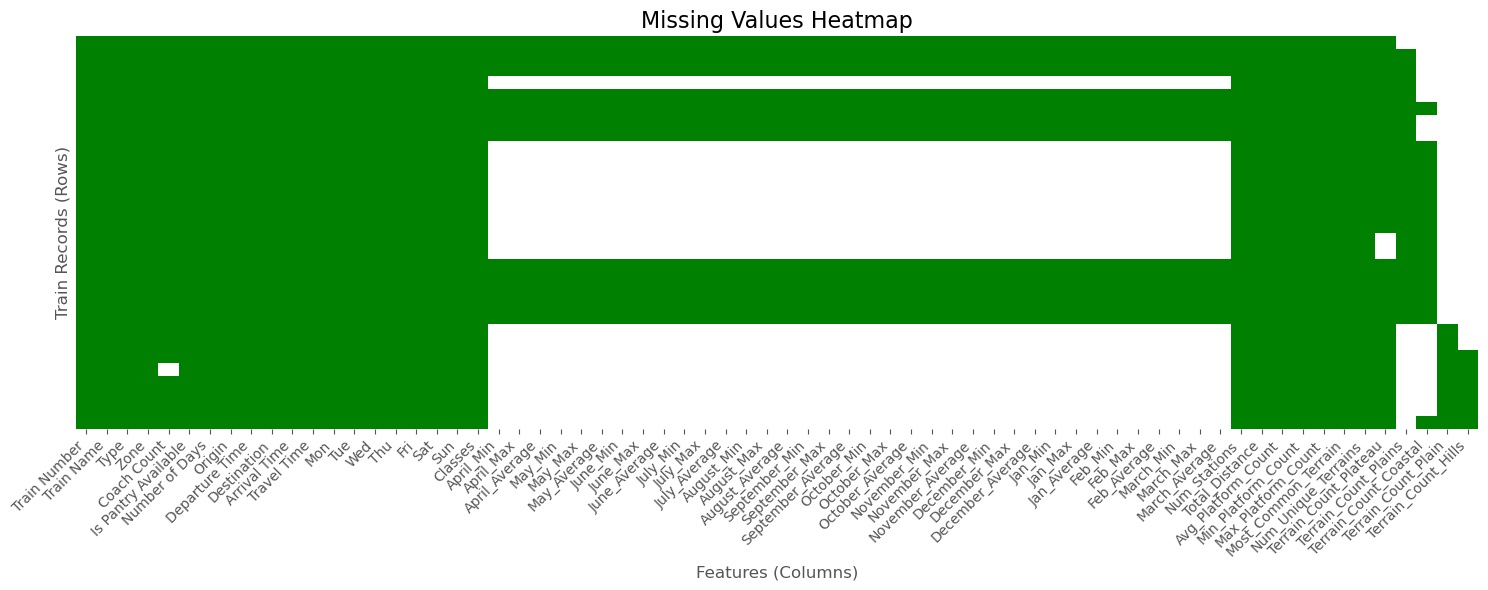

In [256]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

# Plot missing values heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(
    master_df.isnull(),
    cbar=False,
    cmap=['green', 'white'],  # white = missing, black = present
    yticklabels=False
)

plt.title('Missing Values Heatmap', fontsize=16)
plt.xlabel('Features (Columns)', fontsize=12)
plt.ylabel('Train Records (Rows)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()


### Step 5: EDA – Part 3: Delay Distribution Analysis

In this step, we explore how delays are distributed across trains.

- Plot the distribution of `Average Mode Delay` (used to define target later)
- Create boxplots for each month to visualize min/max/median delays
- Check for outliers or skewed distributions
- Look for seasonality or monthly delay patterns

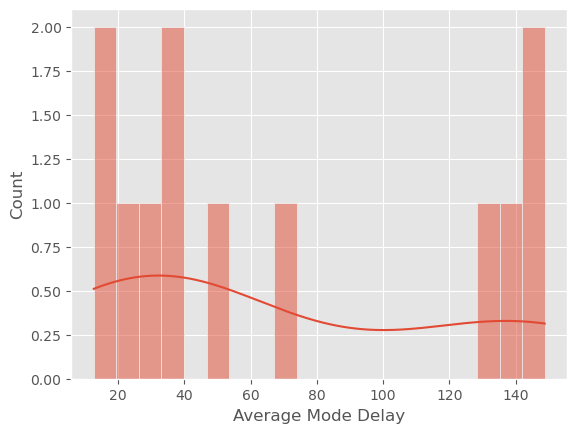

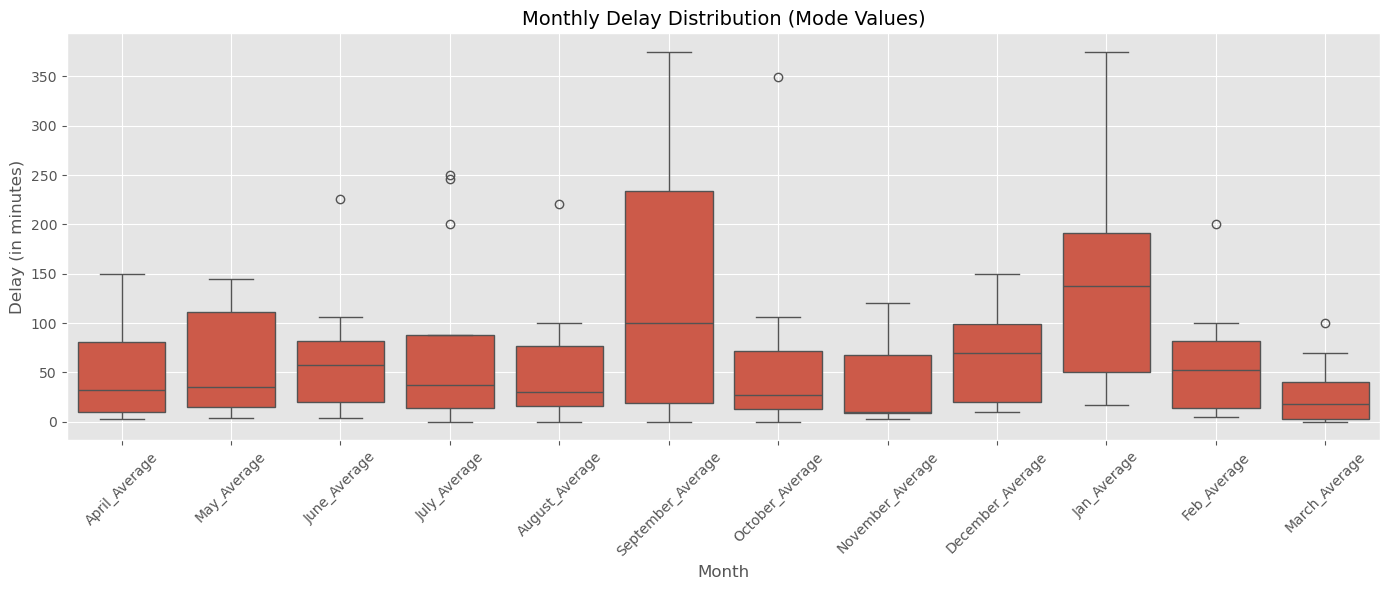

In [257]:
# Extract monthly _Average columns
average_cols = [col for col in master_df.columns if '_Average' in col]

# Create new column: Average Mode Delay (across months)
master_df['Average Mode Delay'] = master_df[average_cols].mean(axis=1)

sns.histplot(master_df['Average Mode Delay'].dropna(), bins=20, kde=True)


# Box Plot for Monthly average delay
average_cols = [col for col in master_df.columns if '_Average' in col and any(month in col for month in ['April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'Jan', 'Feb', 'March'])]

monthly_delay = master_df[['Train Number'] + average_cols].melt(id_vars='Train Number', var_name='Month', value_name='Delay')

plt.figure(figsize=(14, 6))
sns.boxplot(x='Month', y='Delay', data=monthly_delay)
plt.title('Monthly Delay Distribution (Mode Values)', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Delay (in minutes)')
plt.grid(True)
plt.tight_layout()
plt.show()

### Step 6 (Alternative): Creating Quantile-Based Delay Categories

This approach divides `Average Mode Delay` into equal-sized buckets using quantiles (e.g., 5 buckets = quintiles).  
This can help:
- Balance class distribution
- Allow the model to learn delay severity levels based on actual data spread

In [258]:
#average_cols = [col for col in master_df.columns if '_Average' in col]
#master_df['Average Mode Delay'] = master_df[average_cols].mean(axis=1)

#valid_delays = master_df['Average Mode Delay'].dropna()

# Create 5 quantile-based buckets (quintiles)
#quantile_labels = ['Q1_Lowest', 'Q2_Low', 'Q3_Medium', 'Q4_High', 'Q5_Highest']
#master_df['Quantile Delay Category'] = pd.qcut(valid_delays, q=5, labels=quantile_labels)

# For NaN delays, assign 'Unknown'
#master_df['Quantile Delay Category'] = master_df['Quantile Delay Category'].cat.add_categories('Unknown')
#master_df['Quantile Delay Category'] = master_df['Quantile Delay Category'].fillna('Unknown')

#print("Quantile-based category counts:")
#print(master_df['Quantile Delay Category'].value_counts())

### Step 6: Creating Delay Category Labels (Target Variable)

In this step, we convert the continuous average delay into meaningful delay categories:

- Categories: `No Delay`, `Low`, `Medium`, `High`, `Very High`
- Based on `Average Mode Delay` calculated from monthly delay data
- These classes will serve as target labels for classification models

In [259]:
average_cols = [col for col in master_df.columns if '_Average' in col]
master_df['Average Mode Delay'] = master_df[average_cols].mean(axis=1)

def categorize_delay(delay):
    if pd.isna(delay):
        return 'Unknown'
    elif delay == 0:
        return 'No Delay'
    elif delay <= 10:
        return 'Low'
    elif delay <= 30:
        return 'Medium'
    elif delay <= 60:
        return 'High'
    else:
        return 'Very High'

# Step 3: Apply the function
master_df['Delay Category'] = master_df['Average Mode Delay'].apply(categorize_delay)

# Step 4: Check distribution
print(master_df['Delay Category'].value_counts())

Delay Category
Unknown      18
Very High     5
Medium        4
High          3
Name: count, dtype: int64


## Compare the two categorization approaches 

In [260]:
# Compare value counts side by side
#comparison_df = pd.DataFrame({
#    'Manual Category': master_df['Delay Category'].value_counts(),
#    'Quantile Category': master_df['Quantile Delay Category'].value_counts()
#})
#print(comparison_df)

### Step 6 (Visualization): Comparing Manual vs Quantile-Based Delay Categories

This visualization helps compare the distribution of:
- Manually defined delay classes (e.g., Low, Medium, High)
- Quantile-based classes (Q1 to Q5)

This is useful to decide which labeling strategy better suits your modeling goals.

In [261]:
import matplotlib.pyplot as plt

# Create value counts for both
#manual_counts = master_df['Delay Category'].value_counts().sort_index()
#quantile_counts = master_df['Quantile Delay Category'].value_counts().sort_index()

# Combine into a DataFrame
#cat_comparison_df = pd.DataFrame({
#    'Manual': manual_counts,
#    'Quantile-Based': quantile_counts
#}).fillna(0)

# Plotting
#cat_comparison_df.plot(kind='bar', figsize=(10, 6))
#plt.title('Comparison of Delay Category Distribution', fontsize=14)
#plt.ylabel('Number of Trains')
#plt.xticks(rotation=45)
#plt.grid(axis='y')
#plt.tight_layout()
#plt.show()

### Step 5: EDA – Part 4: Correlation Matrix for Numeric Features

This step explores correlations between all numeric features in the dataset, including `Average Mode Delay`.

**Goals**:
- Identify which features are highly correlated with each other (redundancy)
- Spot features strongly correlated with delay (e.g., `Coach Count`, `Total Distance`)
- Use insights to guide feature selection and model tuning

Note: Correlation analysis only applies to numeric columns and measures **linear relationships**.

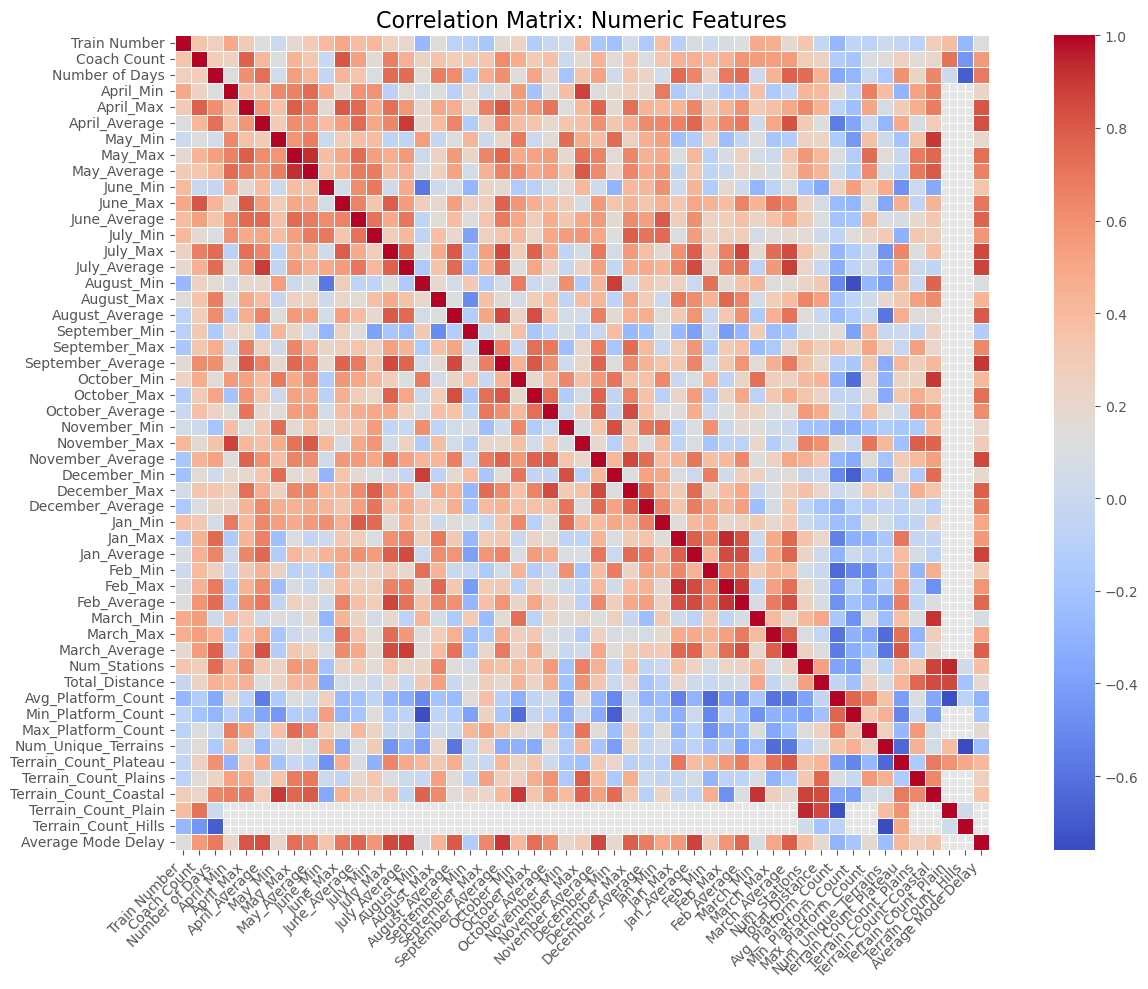

In [262]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract only numeric columns
numeric_cols = master_df.select_dtypes(include=['number'])

# Compute correlation matrix
correlation_matrix = numeric_cols.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", 
            linewidths=0.5, cbar=True, square=True)

plt.title('Correlation Matrix: Numeric Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Top Correlations with Average Mode Delay

To simplify interpretation, we list the top numerical features that show the strongest linear correlation (positive or negative) with `Average Mode Delay`.

This helps focus on features most likely to influence delay severity.

In [263]:
# Get correlations with 'Average Mode Delay'
target_corr = correlation_matrix['Average Mode Delay'].drop('Average Mode Delay')

# Sort by absolute correlation value
top_corr = target_corr.reindex(target_corr.abs().sort_values(ascending=False).index)

print("Top features correlated with 'Average Mode Delay':\n")
print(top_corr.head(10))

Top features correlated with 'Average Mode Delay':

September_Average    0.904208
July_Average         0.875975
Jan_Average          0.875005
July_Max             0.861192
November_Average     0.856654
April_Average        0.839484
April_Max            0.808372
August_Average       0.799222
December_Max         0.783602
March_Average        0.780323
Name: Average Mode Delay, dtype: float64


#### Feature-to-Feature Correlation Analysis

This section checks for **strong correlations between input features** to detect redundancy.

- Highly correlated features (e.g., > 0.85 or < -0.85) may carry duplicate information
- Removing one of the pair can improve model simplicity and reduce noise

In [264]:
# Get numeric features only (excluding the target column)
numeric_cols = master_df.select_dtypes(include='number').drop(columns=['Average Mode Delay'])

# Compute correlation matrix
feature_corr = numeric_cols.corr().abs()

# Select upper triangle of correlation matrix to avoid duplicates
upper_triangle = feature_corr.where(
    np.triu(np.ones(feature_corr.shape), k=1).astype(bool)
)

# Find feature pairs with correlation > 0.85
high_corr_pairs = [
    (col1, col2, upper_triangle.loc[col1, col2])
    for col1 in upper_triangle.columns
    for col2 in upper_triangle.columns
    if pd.notnull(upper_triangle.loc[col1, col2]) and upper_triangle.loc[col1, col2] > 0.85
]

high_corr_pairs.sort(key=lambda x: x[2], reverse=True)

print("Highly correlated feature pairs (corr > 0.85):\n")
for f1, f2, corr in high_corr_pairs:
    print(f"{f1}  ↔  {f2}  →  Correlation: {corr:.2f}")

Highly correlated feature pairs (corr > 0.85):

Num_Stations  ↔  Terrain_Count_Plain  →  Correlation: 0.94
Jan_Max  ↔  Feb_Max  →  Correlation: 0.93
May_Max  ↔  May_Average  →  Correlation: 0.93
March_Min  ↔  Terrain_Count_Coastal  →  Correlation: 0.92
Feb_Max  ↔  Feb_Average  →  Correlation: 0.91
October_Min  ↔  Terrain_Count_Coastal  →  Correlation: 0.90
May_Min  ↔  Terrain_Count_Coastal  →  Correlation: 0.90
April_Average  ↔  July_Average  →  Correlation: 0.90
August_Min  ↔  December_Min  →  Correlation: 0.89
July_Average  ↔  March_Average  →  Correlation: 0.89
April_Min  ↔  November_Max  →  Correlation: 0.88
Num_Stations  ↔  Terrain_Count_Coastal  →  Correlation: 0.87
July_Max  ↔  Feb_Average  →  Correlation: 0.86
Total_Distance  ↔  Terrain_Count_Plain  →  Correlation: 0.86
November_Average  ↔  December_Max  →  Correlation: 0.86
July_Max  ↔  September_Average  →  Correlation: 0.85
August_Average  ↔  September_Average  →  Correlation: 0.85


In [265]:
def preprocess_input(df):
    df = df.copy()

    # Encode binary features if present
    if 'Is Pantry Available' in df.columns:
        df['Is Pantry Available'] = df['Is Pantry Available'].map({'Yes': 1, 'No': 0})
    else:
        df['Is Pantry Available'] = 0

    # Encode Type safely
    df['Type'] = df['Type'].astype('category').cat.codes if 'Type' in df.columns else 0

    # Encode Zone safely
    df['Zone'] = df['Zone'].astype('category').cat.codes if 'Zone' in df.columns else 0

    # Encode Classes
    df['Classes'] = df['Classes'].fillna('').apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0) if 'Classes' in df.columns else 0

    # Parse time safely with explicit format (assuming HH:MM format)
    time_format = "%H:%M"

    if 'Departure Time' in df.columns:
        df['Departure Time Parsed'] = pd.to_datetime(df['Departure Time'], format=time_format, errors='coerce')
        df['Departure_Hour'] = df['Departure Time Parsed'].dt.hour.fillna(0).astype(int)
        df['Departure_Minute'] = df['Departure Time Parsed'].dt.minute.fillna(0).astype(int)
        df.drop(columns=['Departure Time Parsed'], inplace=True)
    else:
        df['Departure_Hour'] = 0
        df['Departure_Minute'] = 0

    if 'Arrival Time' in df.columns:
        df['Arrival Time Parsed'] = pd.to_datetime(df['Arrival Time'], format=time_format, errors='coerce')
        df['Arrival_Hour'] = df['Arrival Time Parsed'].dt.hour.fillna(0).astype(int)
        df['Arrival_Minute'] = df['Arrival Time Parsed'].dt.minute.fillna(0).astype(int)
        df.drop(columns=['Arrival Time Parsed'], inplace=True)
    else:
        df['Arrival_Hour'] = 0
        df['Arrival_Minute'] = 0

    # Calculate Travel Time (minutes)
    if 'Arrival Time' in df.columns and 'Departure Time' in df.columns:
        try:
            arrival = pd.to_datetime(df['Arrival Time'], format=time_format, errors='coerce')
            departure = pd.to_datetime(df['Departure Time'], format=time_format, errors='coerce')
            travel_time = (arrival - departure).dt.total_seconds() / 60.0
            df['Travel Time'] = travel_time.fillna(travel_time.mean())
        except:
            df['Travel Time'] = 0
    else:
        df['Travel Time'] = 0

    # Day of week
    df['Day_of_Week'] = pd.to_datetime(df['Date'], errors='coerce').dt.weekday if 'Date' in df.columns else 0

    # Month encoding
    df['Month'] = pd.to_datetime(df['Date'], errors='coerce').dt.month_name() if 'Date' in df.columns else 'January'

    months = ['January', 'February', 'March', 'April', 'May', 'June',
              'July', 'August', 'September', 'October', 'November', 'December']

    for m in months:
        df[f'{m}_Average'] = df['Month'].apply(lambda x: 5.0 if x == m else 0.0)
        df[f'{m}_Max'] = df['Month'].apply(lambda x: 10.0 if x == m else 0.0)
        df[f'{m}_Min'] = df['Month'].apply(lambda x: 2.0 if x == m else 0.0)
        df[f'{m}_Class'] = df['Month'].apply(lambda x: 1 if x == m else 0)

    # Number of Days based on "Days of Run"
    df['Number of Days'] = df['Days of Run'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0) if 'Days of Run' in df.columns else 0
    
    # Encode Terrain (multi-select as comma-separated string)
    if 'Terrain' in df.columns:
        from sklearn.preprocessing import MultiLabelBinarizer
        df['Terrain'] = df['Terrain'].fillna('')
        terrain_lists = df['Terrain'].apply(lambda x: [t.strip() for t in x.split(',') if t.strip()])
        mlb = MultiLabelBinarizer()
        terrain_encoded = pd.DataFrame(mlb.fit_transform(terrain_lists), columns=mlb.classes_, index=df.index)
        df = pd.concat([df.drop(columns=['Terrain']), terrain_encoded], axis=1)
    else:
        pass  # Handle later during inference

    # Drop unwanted columns
    drop_cols = ['Train Name', 'Date', 'Departure Time', 'Arrival Time', 'Month',
                 'Origin', 'Destination', 'Days of Run']
    df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

    # Drop non-numeric columns if any
    for col in df.columns:
        if df[col].dtype == 'object':
            #print(f"Dropping non-numeric column: {col}")
            df.drop(columns=[col], inplace=True)

    # Compute Delay Category from Average Mode Delay
    if 'Average Mode Delay' in df.columns:
        def categorize_delay(delay):
            if pd.isna(delay):
                return 'Unknown'
            elif delay == 0:
                return 'No Delay'
            elif delay <= 10:
                return 'Low'
            elif delay <= 30:
                return 'Medium'
            elif delay <= 60:
                return 'High'
            else:
                return 'Very High'
        
        df['Delay Category'] = df['Average Mode Delay'].apply(categorize_delay)
    else:
        df['Delay Category'] = 'Unknown'

    return df

In [266]:

# Ensure 'Delayed' column exists
if 'Delayed' not in df.columns:
    # Example: create it from delay minutes if such a column exists
    if 'Delay_Minutes' in df.columns:
        df['Delayed'] = df['Delay_Minutes'].apply(lambda x: 1 if x > 0 else 0)
    else:
        # Otherwise, create a dummy column (not ideal but allows code to run)
        df['Delayed'] = 0


In [267]:
# Train the model
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import pickle


average_cols = [col for col in master_df.columns if '_Average' in col]
master_df['Average Mode Delay'] = master_df[average_cols].mean(axis=1)
# Apply preprocessing
processed_df = preprocess_input(master_df)
processed_df = processed_df[processed_df['Delay Category'] != 'Unknown']

# Separate features and target
X = processed_df.drop('Delay Category', axis=1)
y = processed_df['Delay Category']

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print class distribution
print("Target class distribution:")
print(y.value_counts())

# Train the classifier
model = RandomForestClassifier(random_state=42)
model.fit(X, y_encoded)

# Save the model
with open("trains_delay_prediction_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Save the label encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

with open("model_input_columns_rf.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)

print("✅ Model trained and saved as trains_delay_prediction_model.pkl")

Target class distribution:
Delay Category
Very High    5
Medium       4
High         3
Name: count, dtype: int64
✅ Model trained and saved as trains_delay_prediction_model.pkl


### Step 7: Model Training – XGBoost Classifier

In this step, we train an XGBoost Classifier on the same feature set to compare its performance against Random Forest.

- XGBoost is a gradient boosting algorithm optimized for speed and accuracy on structured/tabular data.
- It uses a boosting strategy where new trees correct the errors of previous ones.
- We use the same train-test split and evaluate with accuracy and confusion matrix for fair comparison.

In [268]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import pickle

# Split the dataset (stratified to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Train XGBoost on the training data
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Save the trained model
with open("xgboost_trains_delay_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

with open("model_input_columns_xgb.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)

print("✅ XGBoost model trained and saved as xgboost_trains_delay_model.pkl")

✅ XGBoost model trained and saved as xgboost_trains_delay_model.pkl


### Step 8: Evaluating XGBoost Classifier

We evaluate the XGBoost model on the entire training dataset to understand how well it fits the data.

- Accuracy score
- Confusion matrix
- Precision, Recall, F1-score for each delay category

In [269]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Predict on test data
y_pred = xgb_model.predict(X_test)

# Evaluate model performance
print("📊 XGBoost Test Accuracy:", accuracy_score(y_test, y_pred))
print("\n🔁 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

📊 XGBoost Test Accuracy: 1.0

🔁 Confusion Matrix:
 [[1 0 0]
 [0 1 0]
 [0 0 1]]

📄 Classification Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00         1
      Medium       1.00      1.00      1.00         1
   Very High       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



### Step 11: Training Logistic Regression Model

We now train a Logistic Regression classifier on the train dataset. This linear model is useful as a baseline and helps interpret feature relationships more easily.


In [270]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import pickle

# Drop columns that are entirely NaN in training set
X_train_cleaned = X_train.dropna(axis=1, how='all')
X_test_cleaned = X_test[X_train_cleaned.columns]  # Align columns

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_cleaned)
X_test_imputed = imputer.transform(X_test_cleaned)

# Train Logistic Regression
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_imputed, y_train)

# Save model and imputer
with open("logistic_regression_trains_delay_model.pkl", "wb") as f:
    pickle.dump(logreg_model, f)

with open("logreg_imputer.pkl", "wb") as f:
    pickle.dump(imputer, f)

with open("model_input_columns_logreg.pkl", "wb") as f:
    pickle.dump(X_train_cleaned.columns.tolist(), f)

print("✅ Logistic Regression model trained and saved")

✅ Logistic Regression model trained and saved


### Step 12: Evaluating Logistic Regression Model

We evaluate the Logistic Regression model on the test set using accuracy, confusion matrix, and classification metrics.

In [271]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Predict on the imputed test data
y_pred_logreg = logreg_model.predict(X_test_imputed)

# Evaluation metrics
print("📊 Logistic Regression Test Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("\n🔁 Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred_logreg, target_names=label_encoder.classes_))

📊 Logistic Regression Test Accuracy: 1.0

🔁 Confusion Matrix:
 [[1 0 0]
 [0 1 0]
 [0 0 1]]

📄 Classification Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00         1
      Medium       1.00      1.00      1.00         1
   Very High       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



### Step 13: Training SVM Classifier

We train a Support Vector Machine (SVM) classifier on the same training data. SVMs are effective for high-dimensional spaces and are good at separating classes with clear margins.


In [272]:
from sklearn.svm import SVC
import pickle

# Initialize and train SVM on imputed data
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_imputed, y_train)

# Save the SVM model
with open("svm_trains_delay_model.pkl", "wb") as f:
    pickle.dump(svm_model, f)

with open("model_input_columns_svm.pkl", "wb") as f:
    pickle.dump(X_train_cleaned.columns.tolist(), f)

print("✅ SVM model trained and saved as svm_trains_delay_model.pkl")

✅ SVM model trained and saved as svm_trains_delay_model.pkl


### Step 14: Evaluating SVM Classifier

We now evaluate the SVM classifier on the test data using accuracy, confusion matrix, and classification metrics.

In [273]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Predict on test data
y_pred_svm = svm_model.predict(X_test_imputed)

# Evaluate model performance safely
print("📊 SVM Test Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\n🔁 Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("\n📄 Classification Report:\n", classification_report(
    y_test, y_pred_svm, target_names=label_encoder.classes_, zero_division=0
))

📊 SVM Test Accuracy: 0.3333333333333333

🔁 Confusion Matrix:
 [[0 0 1]
 [0 0 1]
 [0 0 1]]

📄 Classification Report:
               precision    recall  f1-score   support

        High       0.00      0.00      0.00         1
      Medium       0.00      0.00      0.00         1
   Very High       0.33      1.00      0.50         1

    accuracy                           0.33         3
   macro avg       0.11      0.33      0.17         3
weighted avg       0.11      0.33      0.17         3



Step 15: Comparison of All Models (Test Set Results)
This table summarizes the performance of all trained classifiers on the test set (3 samples total: 1 per class):

Metric&nbsp;&nbsp;Random Forest&nbsp;&nbsp;XGBoost&nbsp;&nbsp;Logistic Regression&nbsp;&nbsp;SVM
<br>Accuracy&nbsp;&nbsp;1.00&nbsp;&nbsp;1.00&nbsp;&nbsp;1.00&nbsp;&nbsp;0.33
<br>Precision&nbsp;&nbsp;1.00&nbsp;&nbsp;1.00&nbsp;&nbsp;1.00&nbsp;&nbsp;0.11
<br>Recall&nbsp;&nbsp;1.00&nbsp;&nbsp;1.00&nbsp;&nbsp;1.00&nbsp;&nbsp;0.33
<br>F1-Score&nbsp;&nbsp;1.00&nbsp;&nbsp;1.00&nbsp;&nbsp;1.00&nbsp;&nbsp;0.17
<br>Classes Predicted&nbsp;&nbsp;All correctly&nbsp;&nbsp;All correctly&nbsp;&nbsp;All correctly&nbsp;&nbsp;Only "Very High"